# Tutorial for using the event distribution module of the structural-color python package

Copyright 2016, Vinothan N. Manoharan, Victoria Hwang, Annie Stephenson

This file is part of the structural-color python package.

This package is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This package is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this package. If not, see http://www.gnu.org/licenses/.

# Introduction to the event distribution module

The event distribution module of the structural-color package allows us to interpret the trajectories run using the Monte Carlo model in this same package. By tracking the event at which a trajectory exits, and how its properties (direction, position, etc.) change as it moves, we can gain insight into the physics of the scattering modelled by our package. 

## Loading and using the package and module

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import structcol as sc
import structcol.refractive_index as ri
from structcol import montecarlo as mc
from structcol import detector as det
from structcol import event_distribution as ed
import seaborn as sns
sns.set_style('white')

# For Jupyter notebooks only:
%matplotlib inline

### Set properties of system

In [3]:
# Monte Carlo parameters
ntrajectories = 30000 # number of trajectories
nevents = 20 # number of scattering events in each trajectory

# source/detector properties
wavelength = sc.Quantity(np.array(550),'nm') # wavelength at which to run simulation 

# sample properties
particle_radius = sc.Quantity('140 nm') # radius of the particles
volume_fraction = sc.Quantity(0.56, '') # volume fraction of particles
z_low = sc.Quantity('0.0 um')
thickness = sc.Quantity('10 um')
particle = 'ps'
matrix = 'air'
boundary = 'film'

# indices of refraction
n_particle = ri.n('polystyrene', wavelength) # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelength)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelength)      # space within sample. n_medium is outside the sample.

### Run photons for a single wavelength

In [8]:
# Calculate the effective refractive index of the sample
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction)

# Calculate the phase function and scattering and absorption coefficients from the single scattering model
# (this absorption coefficient is of the scatterer, not of an absorber added to the system)
p, mu_scat, mu_abs = mc.calc_scat(particle_radius, n_particle, n_sample, volume_fraction, wavelength)
lscat = 1/mu_scat.magnitude # microns

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, boundary)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Generate a matrix of all the randomly sampled angles first 
sintheta, costheta, sinphi, cosphi, theta, _ = mc.sample_angles(nevents, ntrajectories, p)
sintheta = np.sin(theta)
costheta = np.cos(theta)

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)

# Create trajectories object
trajectories = mc.Trajectory(r0, k0, W0)

# Run photons
trajectories.absorb(mu_abs, step)                         
trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
trajectories.move(step)

### Calculate reflectance

Be sure to set return_extra to True in order to return all the additional parameters we'll need to calculate the distribution of the trajectory events

In [11]:
refl_indices, trans_indices,\
inc_refl_per_traj, refl_per_traj, trans_per_traj,\
trans_frac, refl_frac,\
refl_fresnel, trans_fresnel,\
reflectance, transmittance,\
tir_refl_bool, _,_ = det.calc_refl_trans(trajectories, thickness, n_medium, n_sample, boundary, 
                                                                  return_extra = True)

print('Reflectance: ' + str(reflectance))

Reflectance: 0.215240378284


#### Calculating event distribution for a sphere
We can also use the event_distribution for a sample with a sphere boundary. To do this, simply set boundary='sphere' when setting the sample parameters above. See montecarlo_tutorial.ipynb for additional optional parameters that can be set for the sphere case. 

### Calculate event distribution

Input the output from calc_refl_trans() into a function that calculates the how the reflectance is distributed across all the events

In [12]:
refl_events, trans_events = ed.calc_refl_trans_event(refl_per_traj, 
                                                     inc_refl_per_traj, 
                                                     trans_per_traj, 
                                                     refl_indices, 
                                                     trans_indices, 
                                                     nevents)

Plot the event distribution

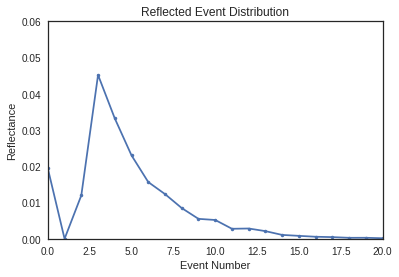

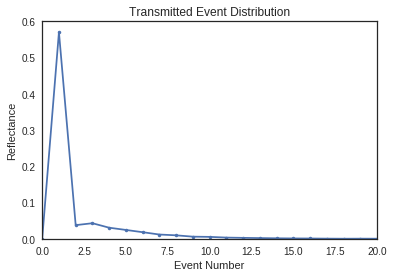

In [13]:
plt.figure()
plt.title('Reflected Event Distribution')
events = np.arange(0, refl_events.size)
plt.plot(events, refl_events, linestyle='-', marker='.')
plt.ylim([0,.06])
plt.xlim([0,nevents])
plt.ylabel('Reflectance')
plt.xlabel('Event Number')

plt.figure()
plt.title('Transmitted Event Distribution')
events = np.arange(0, trans_events.size)
plt.plot(events, trans_events, linestyle='-', marker='.')
plt.ylim([0,0.6])
plt.xlim([0,nevents])
plt.ylabel('Reflectance')
plt.xlabel('Event Number')

In these plots, the 0th event corresponds to the fresnel reflection (or transmission) due to the interface, before entering the sample. The fresnel transmission is 0 for the 0th event because light cannot be transmitted through the sample due to transmission from the first interface. Also, note that the Reflection at the 1st event is 0 because the first event propagates the photons into the sample, meaning none can be reflected at this stage. 

In [14]:
print('Reflectance: ' + str(reflectance))
print('Reflectance event sum: ' + str(np.sum(refl_events)))

Reflectance: 0.215240378284
Reflectance event sum: 0.191348409658


If we compare the reflectance and the sum of the refl_events, you'll notice they are not the same. The refl_events sum is smaller by a few percent. It's smaller because the total reflectance calculation includes a correction for both stuck and fresnel reflected trajectories, and refl_events doesn't.

Stuck trajectories refers to trajectories that haven't been given enough events to be reflected or transmitted. They are still bouncing around inside the sample. To avoid these, simply use a larger number of events.

Fresnel reflected refers to the trajectory weights that are reflected back into the sample due to Fresnel reflection. These partially reflected trajectories are treated differently from those which are totally internally reflected due to Fresnel. The totally internally reflected trajectories are treated as trajectories that have not yet exited and continue to run until they do exit. To correct for the discrepancy caused by the Fresnel reflection, I've implemented several solutions. 

### Correcting for partial Fresnel reflections

I developed two methods to deal with the Fresnel reflected trajectories 

#### option 1: Add the Fresnel reflected weights to the average event for fresnel reflection

This function finds the average event at which Fresnel trajectories are reflected and adds the Fresnel trajectory weights to that event. The problem with this method is that it can result in a sudden jump in reflectance at that event, which seems unphysical.

In [15]:
refl_events_fresnel_avg = ed.calc_refl_event_fresnel_avg(refl_events, refl_indices, trans_indices, 
                                                         refl_fresnel, trans_fresnel,
                                                         refl_frac, trans_frac, nevents)

plot the reflected event distribution with the fresnel correction

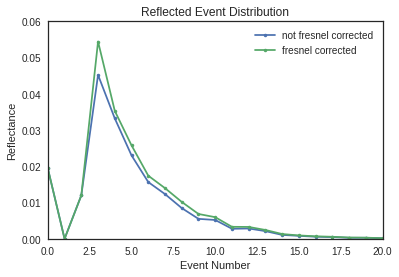

In [16]:
plt.figure()
plt.title('Reflected Event Distribution')
events = np.arange(0, refl_events.size)
plt.plot(events, refl_events, linestyle='-', marker='.', label = 'not fresnel corrected')
plt.plot(events, refl_events_fresnel_avg, linestyle='-', marker='.', label = 'fresnel corrected')
plt.ylim([0,.06])
plt.xlim([0,nevents])
plt.ylabel('Reflectance')
plt.xlabel('Event Number')
plt.legend()

#### option 2: Add the Fresnel reflected weights to an event found by sampling the reflection and transmission spectrum

This requires first calculating a probability density function (pdf) using the reflectance and transmittance spectrum

In [17]:
pdf_refl, pdf_trans = ed.calc_pdf_scat(refl_events, trans_events, nevents)

refl_events_fresnel_samp = ed.calc_refl_event_fresnel_pdf(refl_events, 
                                                          pdf_refl, pdf_trans, refl_indices, trans_indices,
                                                          refl_fresnel, trans_fresnel,
                                                          refl_frac, trans_frac, nevents)

plot the reflected event distribution with the fresnel corrections

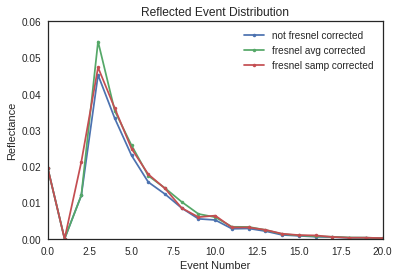

In [18]:
plt.figure()
plt.title('Reflected Event Distribution')
events = np.arange(0, refl_events.size)
plt.plot(events, refl_events, linestyle='-', marker='.', label = 'not fresnel corrected')
plt.plot(events, refl_events_fresnel_avg, linestyle='-', marker='.', label = 'fresnel avg corrected')
plt.plot(events, refl_events_fresnel_samp, linestyle='-', marker='.', label = 'fresnel samp corrected')
plt.ylim([0,.06])
plt.xlim([0,nevents])
plt.ylabel('Reflectance')
plt.xlabel('Event Number')
plt.legend()

In [19]:
print('Reflectance: ' + str(reflectance))
print('Reflectance event sum: ' + str(np.sum(refl_events)))
print('Reflectance event sum fresnel average: ' + str(np.sum(refl_events_fresnel_avg)))
print('Reflectance event sum fresnel sample: ' + str(np.sum(refl_events_fresnel_samp)))

Reflectance: 0.215240378284
Reflectance event sum: 0.191348409658
Reflectance event sum fresnel average: 0.214733745346
Reflectance event sum fresnel sample: 0.214733745346


The fresnel corrected sums of refl_events are larger than the sum without refl_events. 

### Calculating reflectance due to totally internally reflected light

Some trajectories are not just partially fresnel reflected, but are totally internally reflected back into the sample when they attempt to exit. Since we continue to track these photons, we treat them differently from the partially reflected ones. We can calculate several useful values related to the totally internally reflected photons

**tir_all**: the summed weights of photons that are totally internally reflected at any event, regardless of whether they are reflected, transmitted, or stuck

**tir_all_refl**: the summed weights of photons that are totally internally reflected at any event, but only those which eventually contribute to reflectance

**tir_single**: the summed weights of photons that are totally internally reflected after the first scattering event, regardless of whether they are reflected, transmitted, or stuck

**tir_single_refl**: the summed weights of photons that are totally internally reflected after the first scattering event, but only those which eventually contribute to reflectance

**tir_incides_single**: the event indices of photons that are totally internally reflected after a single scattering event

Note: because these are summed weights, you must divide by ntrajectories to normalize

In [21]:
# total internal reflection
tir_all,\
tir_all_refl,\
tir_single,\
tir_single_refl,\
tir_indices_single = ed.calc_tir(tir_refl_bool, refl_indices, trans_indices, inc_refl_per_traj, 
                                 trajectories.weight,
                                 ntrajectories, 
                                 n_sample, 
                                 n_medium,
                                 boundary,
                                 trajectories,
                                 thickness)

In [22]:
print('TIR single refl: ' + str(tir_single_refl/ntrajectories))

TIR single refl: 0.0466938498147


### Getting trajectory properties at exit

At times, we may want to see certain properties of trajectories at their event of reflection. Here we, look at kz, the z-component of the direction and zpos, the z-component of position

In [23]:
ntraj_save = 3000 # number of trajectories to save. 

# intialize the properties we want to save
zpos = np.zeros((nevents+1, ntraj_save))
kz = np.zeros((nevents, ntraj_save))

# find the properties for each event and trajectory
for tr in range(0, ntraj_save):
    zpos[0:int(refl_indices[tr])+1,tr] = trajectories.position[2, 0:int(refl_indices[tr]) + 1, tr]
    kz[0:int(refl_indices[tr]),tr] = trajectories.direction[2,0:int(refl_indices[tr]), tr]

Plot kz of trajectories after second scattering event

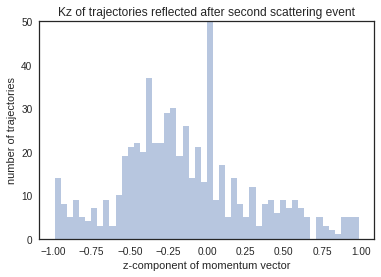

In [24]:
sns.distplot(kz[1,:], kde=False)
plt.ylim(0,50)
plt.ylabel('number of trajectories')
plt.xlabel('z-component of momentum vector')
plt.title('Kz of trajectories reflected after second scattering event')

### Saving and loading results

This function saves the results calculated by the event_distribution module, along with several sample parameters to help with identifying the data file later on. There are several mandatory parameters to save as well as many optional ones. See the docstring for the full list of optional parameters.

save data

In [25]:
ed.save_data(particle,
             matrix,
             particle_radius,
             volume_fraction,
             thickness,
             reflectance,
             refl_events,
             wavelength, 
             nevents, 
             ntrajectories,
             tir_all = tir_all, 
             tir_all_refl = tir_all_refl,
             tir_single = tir_single,
             tir_single_refl = tir_single_refl,
             tir_indices_single = tir_indices_single)

load data from saved file

In [26]:
data = np.load('ps_in_air_ntraj300_nevent20_rad140_vf0.56_thick10_numwl1.npz')
refl_events = data['refl_events']

### Find event distributions for a range of wavelengths 
(for film geometry)

Set properties of system

In [28]:
# Monte Carlo parameters
ntrajectories = 300 # number of trajectories
nevents = 20 # number of scattering events in each trajectory

# source/detector properties
wavelengths = sc.Quantity(np.arange(400,810,20),'nm') # wavelength at which to run simulation 

# sample properties
particle_radius = sc.Quantity('140 nm') # radius of the particles
volume_fraction = sc.Quantity(0.56, '') # volume fraction of particles
z_low = sc.Quantity('0.0 um')
thickness = sc.Quantity('10 um')
particle = 'ps'
matrix = 'air'
boundary = 'film'

# indices of refraction
n_particle = ri.n('polystyrene', wavelengths) # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelengths)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelengths)      # space within sample. n_medium is outside the sample.

Run Monte carlo and event distrubution code

In [30]:
t0_tot = time.time()

# initialize arrays for quanitties we want to look at later
refl_events = np.zeros((wavelengths.size,2*nevents+1))
refl_events_fresnel_samp = np.zeros((wavelengths.size,2*nevents+1))
refl_events_fresnel_avg = np.zeros((wavelengths.size,2*nevents+1))
reflectance = np.zeros(wavelengths.size)
p = np.zeros((wavelengths.size,200))
lscat = np.zeros(wavelengths.size)
tir_single = np.zeros((wavelengths.size))
tir_single_refl = np.zeros((wavelengths.size))
tir_all = np.zeros((wavelengths.size))
tir_all_refl = np.zeros((wavelengths.size))
tir_indices_single = np.zeros((wavelengths.size, ntrajectories))

# run monte carlo, reflectance, and event_distribution
for i in range(wavelengths.size):
    t0 = time.time()
    print(wavelengths[i])
    
    n_sample = ri.n_eff(n_particle[i], n_matrix[i], volume_fraction)
    
    # Calculate the phase function and scattering and absorption coefficients from the single scattering model
    # (this absorption coefficient is of the scatterer, not of an absorber added to the system)
    p[i,:], mu_scat, mu_abs = mc.calc_scat(particle_radius, n_particle[i], n_sample, volume_fraction, wavelengths[i])
    lscat[i] = 1/mu_scat.magnitude # microns
    
    # Initialize the trajectories
    r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium[i], n_sample, boundary)
    r0 = sc.Quantity(r0, 'um')
    k0 = sc.Quantity(k0, '')
    W0 = sc.Quantity(W0, '')
    
    ###############################################################################
    # Generate a matrix of all the randomly sampled angles first 
    sintheta, costheta, sinphi, cosphi, theta, _ = mc.sample_angles(nevents, ntrajectories, p[i,:])
    sintheta = np.sin(theta)
    costheta = np.cos(theta)
    
    # Create step size distribution
    step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)
        
    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)
    
    # Run photons
    trajectories.absorb(mu_abs, step)                         
    trajectories.scatter(sintheta, costheta, sinphi, cosphi)         
    trajectories.move(step)
    
    ################### Calculate reflection and transmition   
    refl_indices, trans_indices,\
    inc_refl_per_traj, refl_per_traj, trans_per_traj,\
    trans_frac, refl_frac,\
    refl_fresnel, trans_fresnel,\
    reflectance[i], transmittance,\
    tir_refl_bool,_,_ = det.calc_refl_trans(trajectories, thickness, n_medium[i], 
                                            n_sample, boundary, return_extra = True)


    ################### Calculate event distributions ##########################
    
    refl_events[i,:], trans_events = ed.calc_refl_trans_event(refl_per_traj, inc_refl_per_traj, trans_per_traj, 
                              refl_indices, trans_indices, nevents)
    
    # total internal reflection
    tir_all[i],\
    tir_all_refl[i],\
    tir_single[i],\
    tir_single_refl[i],\
    tir_indices_single[i,:] = ed.calc_tir(tir_refl_bool, refl_indices, trans_indices, inc_refl_per_traj, 
                                     trajectories.weight,
                                     ntrajectories, 
                                     n_sample, 
                                     n_medium[i],
                                     boundary,
                                     trajectories,
                                     thickness)
    
    # keep track of time to run
    t1 = time.time()
    t_wl = t1-t0
    print('time: ' + str(t_wl/60) + ' min')
    
t_tot = time.time()-t0_tot
print('total time: ' + str(t_tot/3600) + ' hr')

400 nanometer
time: 0.0004547317822774251 min
420 nanometer
time: 0.000505212942759196 min
440 nanometer
time: 0.0004504203796386719 min
460 nanometer
time: 0.0004364609718322754 min
480 nanometer
time: 0.0004452387491861979 min
500 nanometer
time: 0.0004381775856018066 min
520 nanometer
time: 0.00041939417521158853 min
540 nanometer
time: 0.0004631559054056803 min
560 nanometer
time: 0.0007105469703674316 min
580 nanometer
time: 0.00042124191919962564 min
600 nanometer
time: 0.00041000843048095704 min
620 nanometer
time: 0.0004120031992594401 min
640 nanometer
time: 0.0004101832707722982 min
660 nanometer
time: 0.00041245222091674806 min
680 nanometer
time: 0.00041154623031616213 min
700 nanometer
time: 0.0004230618476867676 min
720 nanometer
time: 0.0005653540293375652 min
740 nanometer
time: 0.0005255540211995443 min
760 nanometer
time: 0.000421603520711263 min
780 nanometer
time: 0.0004099408785502116 min
800 nanometer
time: 0.0004091024398803711 min
total time: 0.00015961123837365

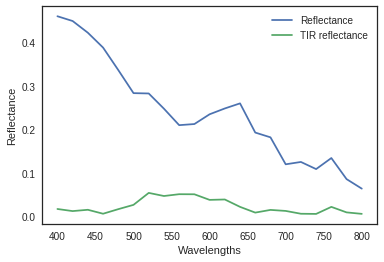

In [31]:
plt.figure()
plt.plot(wavelengths, reflectance, label = 'Reflectance')
plt.plot(wavelengths, tir_single_refl/ntrajectories, label = 'TIR reflectance')
plt.ylabel('Reflectance')
plt.xlabel('Wavelengths')
plt.legend()

##### Save results

In [32]:
ed.save_data(particle,
             matrix,
             particle_radius,
             volume_fraction,
             thickness,
             reflectance,
             refl_events,
             wavelengths, 
             nevents, 
             ntrajectories,
             tir_all = tir_all, 
             tir_all_refl = tir_all_refl,
             tir_single = tir_single,
             tir_single_refl = tir_single_refl,
             tir_indices_single = tir_indices_single)

### Find event distribution of reflectance for a range of scattering angles (for a single wavelength)
(for film geometry)

set parameters of system

In [33]:
# Monte Carlo parameters
ntrajectories = 300 # number of trajectories
nevents = 20 # number of scattering events in each trajectory

# source/detector properties
wavelength = sc.Quantity(np.array(550),'nm') # wavelength at which to run simulation 

# sample properties
particle_radius = sc.Quantity('140 nm') # radius of the particles
volume_fraction = sc.Quantity(0.56, '') # volume fraction of particles
z_low = sc.Quantity('0.0 um')
thickness = sc.Quantity('10 um')
particle = 'ps'
matrix = 'air'

# indices of refraction
n_particle = ri.n('polystyrene', wavelength) # refractive indices can be specified as pint quantities or
n_matrix = ri.n('vacuum', wavelength)      # called from the refractive_index module. n_matrix is the 
n_medium = ri.n('vacuum', wavelength)      # space within sample. n_medium is outside the sample.
n_sample = ri.n_eff(n_particle, n_matrix, volume_fraction)

In [37]:
t0_tot = time.time()

theta_range = sc.Quantity(np.arange(125., 150, 2),'degrees')

refl_events = np.zeros((theta_range.size, 2*nevents+1))
refl_events_fresnel_samp = np.zeros((theta_range.size, 2*nevents+1))
refl_events_fresnel_avg = np.zeros((theta_range.size, 2*nevents+1))
reflectance = np.zeros(theta_range.size)

# Calculate the phase function and scattering and absorption coefficients from the single scattering model
# (this absorption coefficient is of the scatterer, not of an absorber added to the system)
p, mu_scat, mu_abs = mc.calc_scat(particle_radius, n_particle, n_sample, volume_fraction, wavelength)
lscat = 1/mu_scat.magnitude # microns

# Initialize the trajectories
r0, k0, W0 = mc.initialize(nevents, ntrajectories, n_medium, n_sample, boundary)
r0 = sc.Quantity(r0, 'um')
k0 = sc.Quantity(k0, '')
W0 = sc.Quantity(W0, '')

# Create step size distribution
step = mc.sample_step(nevents, ntrajectories, mu_abs, mu_scat)


for j in range(theta_range.size):
    t0 = time.time()
    print(theta_range[j])
    
    # Generate a matrix of all the randomly sampled angles first 
    _, _, sinphi, cosphi, _, _ = mc.sample_angles(nevents, ntrajectories, p)
    theta = np.ones(theta.shape)*theta_range[j].to('rad').magnitude
    sintheta = np.sin(theta)
    costheta = np.cos(theta)
    
    # Create trajectories object
    trajectories = mc.Trajectory(r0, k0, W0)

    # Run photons
    trajectories.absorb(mu_abs, step)    

    trajectories.scatter(sintheta, costheta, sinphi, cosphi)   
    trajectories.move(step)

    ################### Calculate reflection and transmition   
    refl_indices, trans_indices,\
    inc_refl_per_traj, refl_per_traj, trans_per_traj,\
    trans_frac, refl_frac,\
    refl_fresnel, trans_fresnel,\
    reflectance[j], _,_,_,_= det.calc_refl_trans(trajectories, thickness, n_medium, 
                                                                     n_sample, boundary, return_extra = True)


    ################### Calculate event distribution ##########################
    
    refl_events[j,:], trans_events = ed.calc_refl_trans_event(refl_per_traj, inc_refl_per_traj, trans_per_traj, 
                              refl_indices, trans_indices, nevents)
    
    # keep track of time to run
    t1 = time.time()
    t_wl = t1-t0
    print('time: ' + str(t_wl/60) + ' min')
    
t_tot = time.time()-t0_tot
print('total time: ' + str(t_tot/3600) + ' hr')

125.0 degree
time: 0.0002872745196024577 min
127.0 degree
time: 0.00026956001917521156 min
129.0 degree
time: 0.0002668420473734538 min
131.0 degree
time: 0.0002656102180480957 min
133.0 degree
time: 0.0002666592597961426 min
135.0 degree
time: 0.000265196959177653 min
137.0 degree
time: 0.000268860658009847 min
139.0 degree
time: 0.00027751922607421875 min
141.0 degree
time: 0.00027256011962890626 min
143.0 degree
time: 0.0002666473388671875 min
145.0 degree
time: 0.000274205207824707 min
147.0 degree
time: 0.00027698675791422526 min
149.0 degree
time: 0.00030016104380289714 min
total time: 6.226493252648248e-05 hr


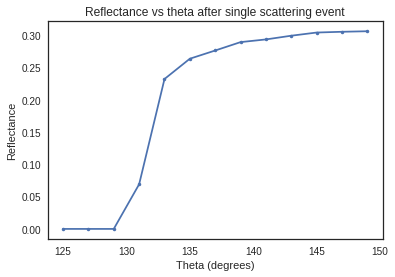

In [38]:
plt.figure()
plt.title('Reflectance vs theta after single scattering event')
plt.plot(theta_range, refl_events[:,2], linestyle='-', marker='.')
plt.ylabel('Reflectance')
plt.xlabel('Theta (degrees)')

##### Save results

In [39]:
ed.save_data(particle,
             matrix,
             particle_radius,
             volume_fraction,
             thickness,
             reflectance,
             refl_events,
             wavelength, 
             nevents, 
             ntrajectories,
             theta_range = theta_range)